In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pycaret.regression import *
import shap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import pickle
import copy
import seaborn as sns

pd.set_option('display.max_colwidth', None)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
data_path = './modeling_df1.csv'

modeling_df = pd.read_csv(data_path).drop(['ReadingScore', 'WritingScore'], axis=1)

modeling_df.shape

(50641, 22)

In [3]:
modeling_df.head()

,ParentEduc_int,TestPrep_int,PracticeSport_int,WklyStudyHours_int,Gender_female,Gender_male,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E,LunchType_free/reduced,LunchType_standard,ParentMaritalStatus_divorced,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed,IsFirstChild_no,IsFirstChild_yes,TransportMeans_private,TransportMeans_school_bus,MathScore
0,2,0,2,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,71
1,1,0,1,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,69
2,3,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,87
3,2,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,45
4,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,76


In [4]:
modeling_df.columns

Index(['ParentEduc_int', 'TestPrep_int', 'PracticeSport_int', 'WklyStudyHours_int', 'Gender_female', 'Gender_male', 'EthnicGroup_group A', 'EthnicGroup_group B', 'EthnicGroup_group C', 'EthnicGroup_group D', 'EthnicGroup_group E', 'LunchType_free/reduced', 'LunchType_standard', 'ParentMaritalStatus_divorced', 'ParentMaritalStatus_married', 'ParentMaritalStatus_single', 'ParentMaritalStatus_widowed', 'IsFirstChild_no', 'IsFirstChild_yes', 'TransportMeans_private', 'TransportMeans_school_bus', 'MathScore'], dtype='object')

# Data Analysis!

In [5]:
corr_mat = modeling_df.corr()
corr_mat

,ParentEduc_int,TestPrep_int,PracticeSport_int,WklyStudyHours_int,Gender_female,Gender_male,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E,LunchType_free/reduced,LunchType_standard,ParentMaritalStatus_divorced,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed,IsFirstChild_no,IsFirstChild_yes,TransportMeans_private,TransportMeans_school_bus,MathScore
ParentEduc_int,1.000000,-0.001988,-0.004001,0.001864,-0.004202,-0.000647,-0.002519,-0.004009,0.006338,0.000750,0.000049,0.007940,-0.003798,0.000281,0.000941,0.001167,0.001999,0.000808,0.003204,-0.001562,-0.000017,0.106914
TestPrep_int,-0.001988,1.000000,-0.003061,-0.000285,0.004082,-0.001732,-0.006242,0.003631,0.003772,-0.000240,-0.001444,0.003629,-0.002378,0.004528,0.000156,-0.000455,-0.006017,0.002273,0.001172,0.001293,-0.003246,0.081765
PracticeSport_int,-0.004001,-0.003061,1.000000,-0.001598,0.000993,0.000709,0.004525,-0.007248,0.004446,-0.001672,0.000585,0.000821,-0.000195,0.002721,0.003192,-0.004503,0.003269,-0.015271,0.011613,-0.005073,0.000234,0.042689
WklyStudyHours_int,0.001864,-0.000285,-0.001598,1.000000,-0.002428,0.006854,0.003960,-0.005222,-0.000935,0.004431,0.001662,0.003452,0.000136,0.001218,-0.002894,0.003970,-0.002079,0.004010,-0.000717,0.006834,0.000056,0.051605
Gender_female,-0.004202,0.004082,0.000993,-0.002428,1.000000,-0.603517,-0.001718,-0.000501,-0.000059,0.002432,0.003479,-0.006356,-0.002013,0.014582,-0.015657,0.006643,-0.007014,0.004926,-0.003798,0.005645,-0.004933,-0.098686
Gender_male,-0.000647,-0.001732,0.000709,0.006854,-0.603517,1.000000,-0.001613,-0.004277,0.004652,0.004413,-0.002402,0.000824,-0.002477,-0.014372,0.008546,-0.006012,0.009309,-0.003672,0.003782,-0.001445,0.005960,0.101186
EthnicGroup_group A,-0.002519,-0.006242,0.004525,0.003960,-0.001718,-0.001613,1.000000,-0.080031,-0.127121,-0.093080,-0.064027,-0.006168,0.001985,0.001316,-0.004991,-0.000878,0.003148,0.002898,-0.001371,0.006660,-0.008345,-0.038682
EthnicGroup_group B,-0.004009,0.003631,-0.007248,-0.005222,-0.000501,-0.004277,-0.080031,1.000000,-0.223979,-0.164975,-0.114787,0.002042,0.001604,-0.005661,-0.001086,0.001255,0.001237,-0.009185,0.004784,-0.004466,0.000633,-0.061477
EthnicGroup_group C,0.006338,0.003772,0.004446,-0.000935,-0.000059,0.004652,-0.127121,-0.223979,1.000000,-0.265500,-0.173746,-0.003516,-0.001873,-0.007834,0.003173,0.007117,0.001787,0.008444,0.002059,0.008656,-0.007058,-0.046746
EthnicGroup_group D,0.000750,-0.000240,-0.001672,0.004431,0.002432,0.004413,-0.093080,-0.164975,-0.265500,1.000000,-0.128729,-0.003849,-0.002171,0.007237,-0.001407,-0.003675,-0.002493,-0.002407,0.001241,-0.007047,0.009107,0.024213


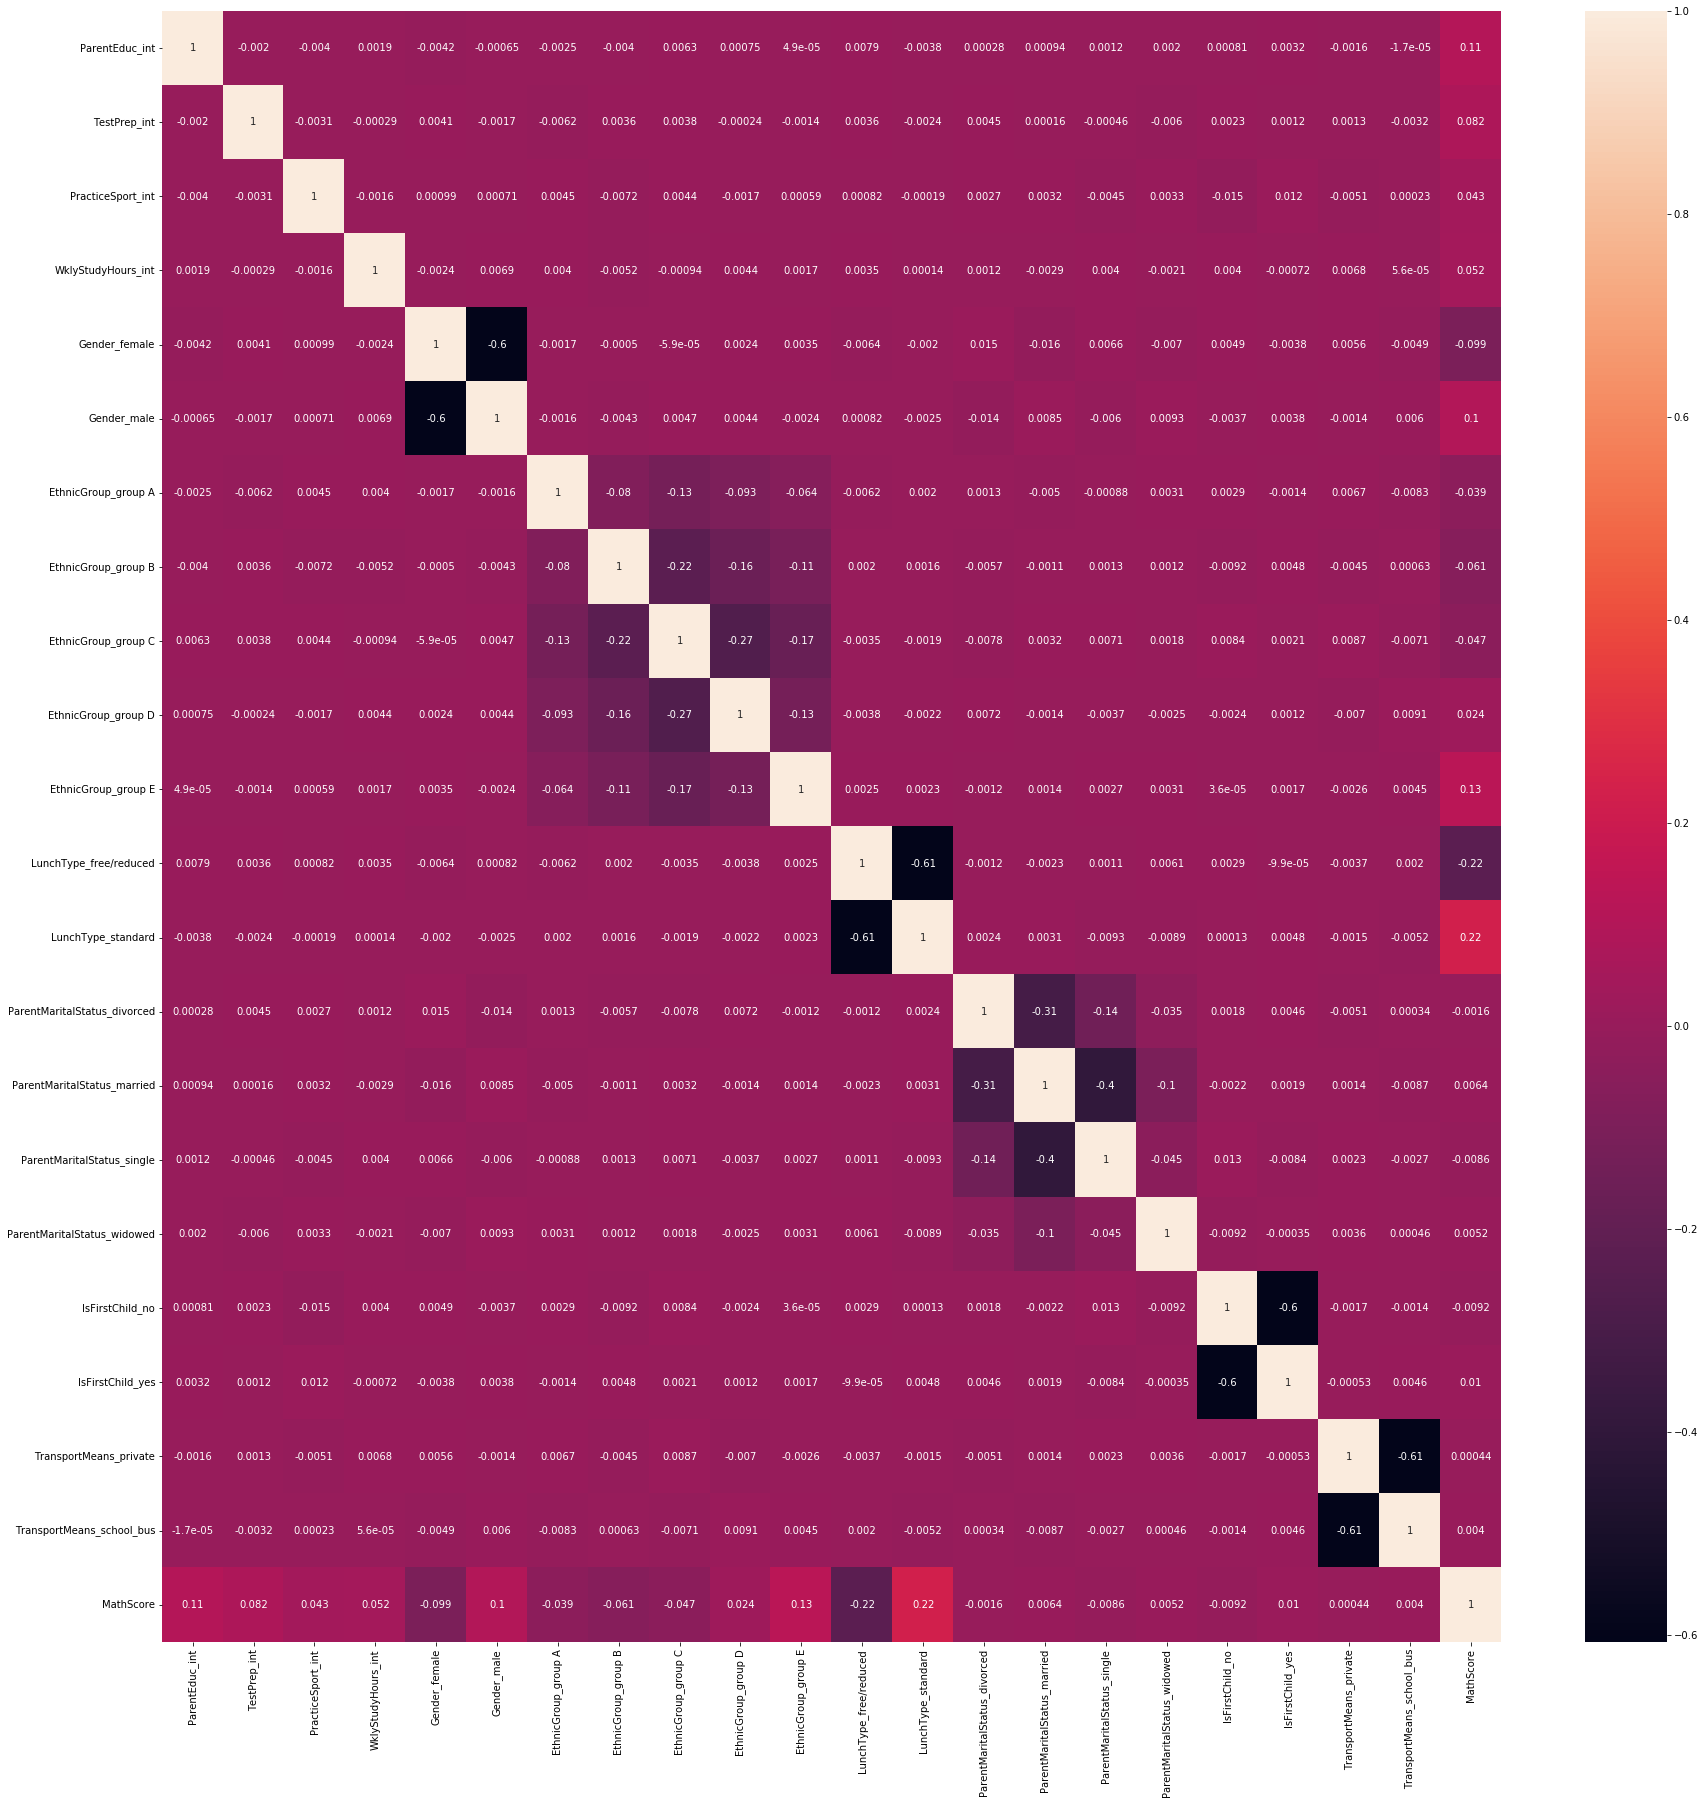

In [6]:
plt.figure(figsize=(30, 30))
sns.color_palette("tab10")
sns.heatmap(modeling_df.corr(), annot=True)

# Calculate MultiCollinearity

#### We are seeing multiple columns with high correlation among themselves. 

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [44]:
variance_inflation_factor??

Signature: variance_inflation_factor(exog, exog_idx)
Source:   
def variance_inflation_factor(exog, exog_idx):
    """
    Variance inflation factor, VIF, for one exogenous variable

    The variance inflation factor is a measure for the increase of the
    variance of the parameter estimates if an additional variable, given by
    exog_idx is added to the linear regression. It is a measure for
    multicollinearity of the design matrix, exog.

    One recommendation is that if VIF is greater than 5, then the explanatory
    variable given by exog_idx is highly collinear with the other explanatory
    variables, and the parameter estimates will have large standard errors
    because of this.

    Parameters
    ----------
    exog : {ndarray, DataFrame}
        design matrix with all explanatory variables, as for example used in
        regression
    exog_idx : int
        index of the exogenous variable in the columns of exog

    Returns
    -------
    float
        variance inflat

In [47]:
vif = pd.DataFrame()
vif["Variable"] = modeling_df.columns
vif['VIF'] = [variance_inflation_factor(modeling_df.values, i) for i in range(modeling_df.shape[1])]
vif

,Variable,VIF
0,ParentEduc_int,2.232982
1,TestPrep_int,1.490702
2,PracticeSport_int,4.245372
3,WklyStudyHours_int,2.829017
4,Gender_female,2.879267
5,Gender_male,2.961780
6,EthnicGroup_group A,1.151946
7,EthnicGroup_group B,1.442925
8,EthnicGroup_group C,1.989116
9,EthnicGroup_group D,1.615039


In [7]:
target = 'MathScore'
# target_metric = 'target_download_throughput'

features = copy.deepcopy(list(modeling_df.columns))
features.remove(target)

In [8]:
features

['ParentEduc_int',
 'TestPrep_int',
 'PracticeSport_int',
 'WklyStudyHours_int',
 'Gender_female',
 'Gender_male',
 'EthnicGroup_group A',
 'EthnicGroup_group B',
 'EthnicGroup_group C',
 'EthnicGroup_group D',
 'EthnicGroup_group E',
 'LunchType_free/reduced',
 'LunchType_standard',
 'ParentMaritalStatus_divorced',
 'ParentMaritalStatus_married',
 'ParentMaritalStatus_single',
 'ParentMaritalStatus_widowed',
 'IsFirstChild_no',
 'IsFirstChild_yes',
 'TransportMeans_private',
 'TransportMeans_school_bus']

In [58]:
X, y = modeling_df[features], modeling_df[target]
X.shape, y.shape

((50641, 21), (50641,))

# Feature Importances

In [59]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

In [64]:
lasso_model = Lasso(alpha=0.03)

In [65]:
selector = SelectFromModel(lasso_model)
selector.fit(X, y)

SelectFromModel(estimator=Lasso(alpha=0.03))

In [62]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True, False, False])

In [66]:
selected_features = X.columns[selector.get_support()]
len(selected_features), len(features)
# X_selected = X[selected_features]

(16, 21)

In [72]:
for i in range(1, 10):
    lasso_model = Lasso(alpha=i/100.)
    selector = SelectFromModel(lasso_model)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    not_selected_features = X.columns[~selector.get_support()]
    print(i/100., len(selected_features), len(features))
    # print(not_selected_features)

0.01 20 21
0.02 17 21
0.03 16 21
0.04 16 21
0.05 15 21
0.06 14 21
0.07 13 21
0.08 13 21
0.09 13 21


#### alpha 0.5 seems fine

In [89]:
not_selected_features

Index(['ParentMaritalStatus_divorced', 'ParentMaritalStatus_married', 'ParentMaritalStatus_single', 'ParentMaritalStatus_widowed', 'IsFirstChild_no', 'IsFirstChild_yes', 'TransportMeans_private', 'TransportMeans_school_bus'], dtype='object')

In [73]:
selected_features

Index(['ParentEduc_int', 'TestPrep_int', 'PracticeSport_int', 'WklyStudyHours_int', 'Gender_female', 'Gender_male', 'EthnicGroup_group A', 'EthnicGroup_group B', 'EthnicGroup_group C', 'EthnicGroup_group D', 'EthnicGroup_group E', 'LunchType_free/reduced', 'LunchType_standard'], dtype='object')

# Train test split

In [76]:
state = 43
ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = ratio, random_state = state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = ratio, random_state = state)

In [77]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((32409, 13), (10129, 13), (8103, 13), (32409,), (10129,), (8103,))

# Training

# Linear Models

### Linear Regression

In [78]:
lin_reg = LinearRegression()

In [79]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [80]:
y_pred = lin_reg.predict(X_test).astype(int)

In [81]:
lin_reg.coef_

array([ 1.73826476,  2.63439091,  1.03503908,  1.21600158, -1.76726916,
        2.04123831, -2.48510187, -2.12819175, -1.21558249,  0.49736308,
        5.36365253, -4.75071223,  4.34238472])

In [82]:
lin_reg.intercept_

60.326805755392364

In [83]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

11.707671043538355


In [84]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

210.50419587323526 14.508762727167168


In [85]:
r2 = r2_score(y_test, y_pred)
r2  # Very less

0.12150733555878035

In [86]:
# Calculate adjusted R-squared
n = len(y_test)
k = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
adjusted_r2

0.12037827924264244

In [87]:
list(y_test[:10])

[76, 80, 77, 58, 74, 48, 58, 70, 41, 81]

In [88]:
list(y_pred[:10])

[68, 63, 69, 64, 65, 58, 63, 63, 59, 75]

### Linear Model - Ridge - L2 Regularisation

In [90]:
from sklearn.linear_model import Ridge

In [91]:
ridge_model = Ridge(alpha=1.0) 
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

In [92]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

11.693559164860096


In [93]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

209.92993655432585 14.488959125980232


In [94]:
r2 = r2_score(y_test, y_pred)
r2  # Very less

0.12390387970867811

In [95]:
# Calculate adjusted R-squared
n = len(y_test)
k = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
adjusted_r2

0.12277790347894135

### Linear Model - Lasso - L1 Regularisation

In [96]:
from sklearn.linear_model import Lasso

In [101]:
ridge_model = Lasso(alpha=0.01) 
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

In [102]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

11.695169778712943


In [103]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

209.95161213221417 14.489707109952711


In [104]:
r2 = r2_score(y_test, y_pred)
r2  # Very less

0.12381342148244934

In [105]:
# Calculate adjusted R-squared
n = len(y_test)
k = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
adjusted_r2

0.12268732899399382

In [106]:
# PCA -  Not now

# Tree Models

## Decision Tree

In [108]:
from sklearn.tree import DecisionTreeRegressor

In [113]:
dtr = DecisionTreeRegressor(max_depth=5)

In [114]:
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

In [115]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

11.743107361731303


In [116]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

212.02145835728928 14.560956642930067


In [117]:
r2 = r2_score(y_test, y_pred)
r2  # Very less

0.11517537644155695

In [118]:
# Calculate adjusted R-squared
n = len(y_test)
k = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
adjusted_r2

0.11403818216511008

## Random Forest Regressor

In [119]:
from sklearn.ensemble import RandomForestRegressor

In [124]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=5)

In [125]:
# RandomForestRegressor??

In [126]:
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

In [127]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

11.715190220839865


In [128]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

210.6675591901433 14.514391450906349


In [129]:
r2 = r2_score(y_test, y_pred)
r2  # Very less

0.12082557491763424

In [131]:
# Calculate adjusted R-squared
n = len(y_test)
k = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
adjusted_r2

0.11969564238910513

## Gradient Boosting Regressor

In [141]:
from sklearn.ensemble import GradientBoostingRegressor

In [142]:
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=5)

In [143]:
# GradientBoostingRegressor??

In [144]:
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

In [145]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

11.563760338468303


In [146]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

205.33364358616055 14.329467665833247


In [147]:
r2 = r2_score(y_test, y_pred)
r2  # Very less

0.14308549097968348

In [148]:
# Calculate adjusted R-squared
n = len(y_test)
k = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
adjusted_r2

0.14198416733981567

# SVR Model

## SVR

In [149]:
from sklearn.svm import SVR

In [151]:
svr = SVR(kernel='poly', degree=4)

In [152]:
# SVR??

In [153]:
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

In [154]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

11.59770884924171


In [155]:
mse = mean_squared_error(y_test, y_pred, squared=True)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mse, rmse)

206.79924967558546 14.3805163215924


In [156]:
r2 = r2_score(y_test, y_pred)
r2  # Very less

0.13696910839082754

In [157]:
# Calculate adjusted R-squared
n = len(y_test)
k = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
adjusted_r2

0.1358599238539102

# SHAP :-)

In [159]:
explainer = shap.TreeExplainer(model=gbr, data=X_train)

In [160]:
shap_values = explainer(X_test)
shap_values

 97%|=================== | 9842/10129 [00:31<00:00]       

.values =
array([[ 0.03653019,  1.24104514, -0.28427709, ..., -0.26988591,
         1.51791742,  1.62094032],
       [-0.40165924, -0.50061214, -0.23560144, ..., -0.08104353,
         1.74954781, -1.19367498],
       [ 0.47030645, -0.45832434,  0.08853563, ..., -0.19690681,
         1.82079677,  1.64161615],
       ...,
       [ 0.01563107,  0.71003039, -0.0726791 , ..., -0.25127063,
        -1.25488602,  1.1785371 ],
       [ 0.63620893, -0.6426101 ,  0.12091529, ..., -0.55456407,
         1.52625549,  1.19803559],
       [ 1.04516233, -0.74967345, -0.20271274, ..., -0.4626613 ,
         1.84791091,  1.95724839]])

.base_values =
array([66.06455933, 66.06455933, 66.06455933, ..., 66.06455933,
       66.06455933, 66.06455933])

.data =
array([[1, 1, 1, ..., 0, 0, 1],
       [1, 0, 2, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 1],
       ...,
       [2, 1, 1, ..., 0, 1, 1],
       [2, 0, 1, ..., 0, 0, 1],
       [2, 0, 1, ..., 0, 0, 1]])

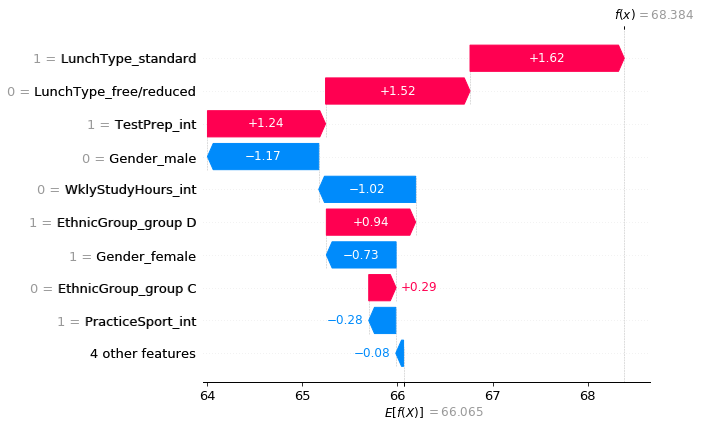

In [161]:
row_num = 0
shap.waterfall_plot(shap_values[row_num])

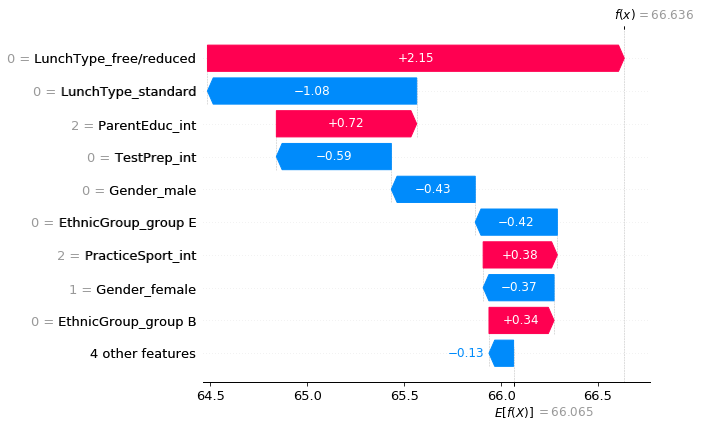

In [163]:
row_num = 162
shap.waterfall_plot(shap_values[row_num])

In [189]:
shap.initjs()

 97%|=================== | 9866/10129 [00:30<00:00]       

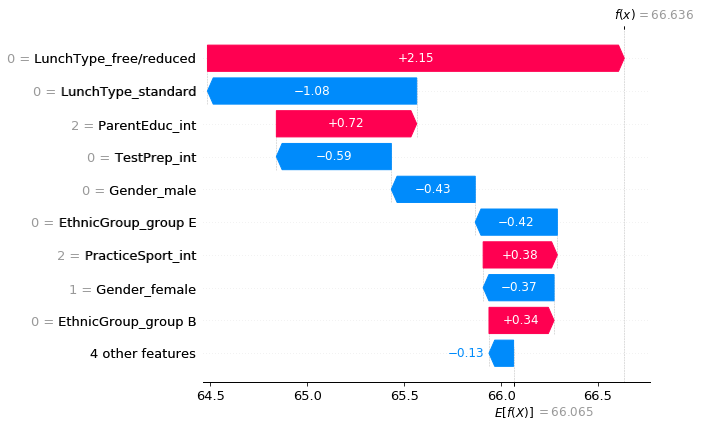

In [192]:
row_num = 162
shap_values = explainer(X_test)
shap.waterfall_plot(shap_values[row_num])

In [193]:
row_num = 162
shap_values = explainer.shap_values(X_test.iloc[row_num])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[row_num], feature_names=selected_features)

In [166]:
selected_features

Index(['ParentEduc_int', 'TestPrep_int', 'PracticeSport_int', 'WklyStudyHours_int', 'Gender_female', 'Gender_male', 'EthnicGroup_group A', 'EthnicGroup_group B', 'EthnicGroup_group C', 'EthnicGroup_group D', 'EthnicGroup_group E', 'LunchType_free/reduced', 'LunchType_standard'], dtype='object')

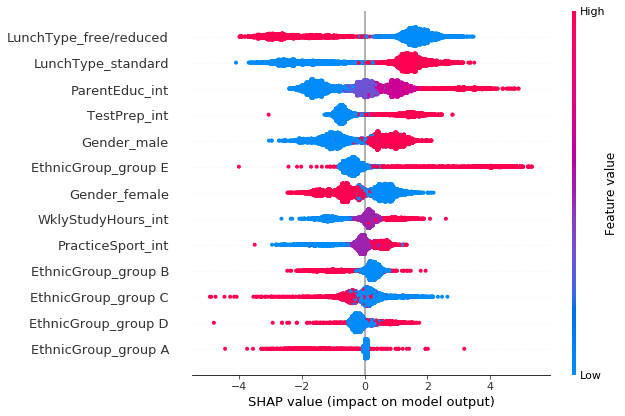

In [162]:
shap.summary_plot(shap_values, X_test)